In [1]:
import torch
import torch.nn as nn
import torch.autograd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Net1D(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net1D, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.tanh(self.hidden(x))
        x = self.output(x)
        return x

In [3]:
def compute_loss(net, x, t):
    xt = torch.cat([x, t], dim=1)
    xt.requires_grad = True
    
    u = net(xt)
    grads = torch.autograd.grad(u, xt, create_graph=True, grad_outputs=torch.ones_like(u))
    u_t = grads[0][:, 1:2]
    u_x = grads[0][:, 0:1]
    u_xx = torch.autograd.grad(u_x, xt, create_graph=True, grad_outputs=torch.ones_like(u_x))[0][:, 0:1]
    
    # PDE Loss
    pde_loss = (u_t - u_xx).pow(2).mean()
    
    # Boundary condition losses
    u_left = net(torch.cat([torch.zeros_like(t), t], dim=1))
    u_right = net(torch.cat([torch.ones_like(t), t], dim=1))
    bc_loss = u_left.pow(2).mean() + u_right.pow(2).mean()
    
    # Initial condition loss
    u_init = net(torch.cat([x, torch.zeros_like(x)], dim=1))
    ic_loss = (u_init - torch.sin(np.pi * x)).pow(2).mean()
    
    # Total Loss
    loss = pde_loss + bc_loss + ic_loss
    
    return loss

In [4]:
# Training
net = Net1D(2, 20, 1)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

training_steps = [0, 5000, 10000,15000,20000,25000,30000,35000,40000]
solutions = []

for steps in training_steps:
    for epoch in range(steps):
        optimizer.zero_grad()
        x_rand = torch.rand(10, 1)
        t_rand = torch.rand(10, 1)
        loss = compute_loss(net, x_rand, t_rand)
        loss.backward()
        optimizer.step()

    # Store solution
    x = torch.linspace(0, 1, 100).reshape(-1, 1)
    t = torch.tensor([[0.1]])
    xt = torch.cat([x, t.repeat(100, 1)], dim=1)
    u_pred = net(xt).detach().numpy()
    solutions.append(u_pred)

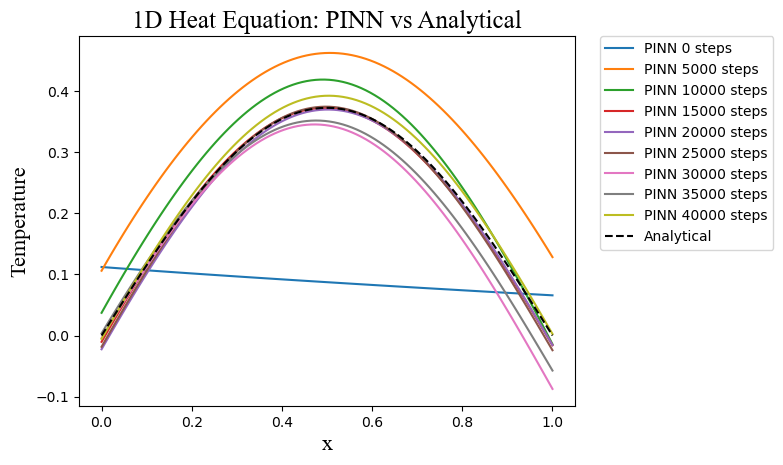

In [5]:
# Analytical solution
x = torch.linspace(0, 1, 100).reshape(-1, 1)
u_true = np.exp(-np.pi**2 * 0.1) * np.sin(np.pi * x.numpy())

# Plotting
for i, steps in enumerate(training_steps):
    plt.plot(x.numpy(), solutions[i], label=f"PINN {steps} steps")

plt.plot(x.numpy(), u_true, 'k--', label="Analytical")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("1D Heat Equation: PINN vs Analytical",fontname='Times New Roman', fontsize=18)
plt.xlabel('x',fontname='Times New Roman', fontsize=16)
plt.ylabel('Temperature',fontname='Times New Roman', fontsize=16)
plt.show()